### Make boundary conditions for present day experiment

Based on observations from B-SOSE (http://sose.ucsd.edu/)

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cmocean
import matplotlib.backends.backend_pdf
import gsw
import sys
sys.path.append('/users/birgal/')
from nemo_python.interpolation import interp_latlon_cf

#### Functions

In [27]:
def prepare_bdy_transect(var, month=1, bdy_lat=-50):
    # Arguments:
    # month --- to look at
    # bdy_lat --- latitude of boundary slice
    # Returns: WOA18 and B-SOSE salinity and temperatures at the specified boundary latitude

    try:
        # Load datasets:
        SOSE_var  = xr.open_dataset(f'{folder_SOSE}{var}_climatology_m{month:02}.nc').sel(YC=slice(bdy_lat-1, bdy_lat+1))
        # Find strip of points nearest bdy_lat (with edges +/- 1 and fill any zeros with NaNs:
        bdy_ind   = np.argmin(np.abs(SOSE_var.YC.values - bdy_lat))
        SOSE_varp = xr.where(SOSE_var[var].isel(YC=slice(bdy_ind-1, bdy_ind+2)) ==0, 
                              np.nan, SOSE_var.isel(YC=slice(bdy_ind-1, bdy_ind+2)))
    except:
        SOSE_var  = xr.open_dataset(f'{folder_SOSE}{var}_climatology_m{month:02}.nc').sel(YG=slice(bdy_lat-1, bdy_lat+1))
        bdy_ind   = np.argmin(np.abs(SOSE_var.YG.values - bdy_lat))
        SOSE_varp = xr.where(SOSE_var[var].isel(YG=slice(bdy_ind-1, bdy_ind+2)) ==0, 
                              np.nan, SOSE_var.isel(YG=slice(bdy_ind-1, bdy_ind+2)))

    # And for SOSE, convert longitudes from 0-360 to -180 to 180 for pcolormesh
    try:
        SOSE_varp['XC']  = xr.where(SOSE_varp.XC  > 180, SOSE_varp.XC  - 360, SOSE_varp.XC)
        SOSE_varp = SOSE_varp.sortby('XC')
    except:
        SOSE_varp['XG']  = xr.where(SOSE_varp.XG  > 180, SOSE_varp.XG  - 360, SOSE_varp.XG)
        SOSE_varp = SOSE_varp.sortby('XG')
    
    return SOSE_varp

In [28]:
def plot_bdy_transect(month, model_S, model_T, SOSE_S, SOSE_T, 
                      Trange=(1,10), Srange=(33.4, 34.6), ylim=(1500,0)):
                         
    fig, ax = plt.subplots(4,1, figsize=(18,12))

    fig.suptitle(f'Month: {month:02}', fontsize=12, fontweight='bold')
                          
    kwargs_T = {'vmin':Trange[0], 'vmax':Trange[1], 'cmap':cmocean.cm.thermal, 'rasterized':True}
    kwargs_S = {'vmin':Srange[0], 'vmax':Srange[1], 'cmap':cmocean.cm.haline, 'rasterized':True}
    
    ax[0].set_title('B-SOSE observations')
    ax[1].set_title('Model boundary condition')
    ax[2].set_title('B-SOSE observations')
    ax[3].set_title('Model boundary condition')
    
    model_T_proc = model_T.sortby('x')
    model_S_proc = model_S.sortby('x')
    model_x, _   = np.meshgrid(model_T_proc.x, model_T_proc.Z)
    model_Z      = mesh.gdept_0.isel(time_counter=0, y=bdy_ind).sortby(model_T.x)
    print(model_x.shape, model_Z.values.shape)
    
    cm1 = ax[0].pcolormesh(SOSE_T.XC, -1*SOSE_T.Z, SOSE_T.THETA, **kwargs_T)
    cm2 = ax[1].pcolormesh(model_x, model_Z, model_T_proc.THETA, **kwargs_T)
    cm3 = ax[2].pcolormesh(SOSE_S.XC, -1*SOSE_S.Z, SOSE_S.SALT, **kwargs_S)
    cm4 = ax[3].pcolormesh(model_x, model_Z, model_S_proc.SALT, **kwargs_S)
    
    CB2 = fig.colorbar(cm2, ax=ax[0:2], fraction=0.03, extend='both', label='Temperature (degC)')
    CB4 = fig.colorbar(cm4, ax=ax[2:], fraction=0.03, extend='both', label='Salinity (g/kg)')
    
    for axis in ax.ravel():
        axis.set_ylabel('Depth (m)')
        axis.invert_yaxis()
        axis.set_ylim(ylim[0],ylim[1])
    ax[3].set_xlabel('Longitude')

    return fig, ax

#### Definitions

In [29]:
# # File locations Jasmin:
# folder_SOSE = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/B-SOSE/climatology/'
# folder_BC   = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/boundary-conditions/'
# folder_NEMO = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/'

# coordinates_file='/gws/nopw/j04/terrafirma/kaight/NEMO_AIS/coordinates_AIS.nc'
# meshmask_file   ='/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/mesh_mask-20231017.nc'

#  File locations BAS:
folder_SOSE = '/data/oceans_output/shelf/birgal/B-SOSE/'
folder_BC   = '/data/oceans_output/shelf/birgal/boundary-conditions/'
folder_NEMO = '/data/oceans_output/shelf/birgal/bathymetry/'

coordinates_file='/data/oceans_output/shelf/birgal/bathymetry/coordinates_AIS.nc'
meshmask_file   ='/data/oceans_output/shelf/birgal/bathymetry/mesh_mask-20231025.nc'

In [30]:
SOSE_Temp = prepare_bdy_transect('THETA') # Potential temperature (degC)
SOSE_Salt = prepare_bdy_transect('SALT') # Salinity (g/kg)
SOSE_Uvel = prepare_bdy_transect('UVEL') # Zonal Component of Velocity (m/s)
SOSE_Vvel = prepare_bdy_transect('VVEL') # Meridional Component of Velocity (m/s)
SOSE_SSH  = prepare_bdy_transect('ETAN') # sea surface height anomoly (m)
SOSE_SIAr = prepare_bdy_transect('SIarea') # SEAICE fractional ice-covered area [0 to 1] (m2/m2)
SOSE_SIHe = prepare_bdy_transect('SIheff') # SEAICE effective ice thickness (m)

#### Make boundary condition

In [103]:
# Load files:
nemo = xr.open_dataset(coordinates_file).squeeze()
mesh = xr.open_dataset(meshmask_file)

nemo_depths = mesh.nav_lev.values

In [21]:
month = 1

# Index of boundary location (Python-based numbering); assumes you want all longitudes
bdy_ind = 452
bdy_lat = nemo.nav_lat.isel(y=452).mean().values
bdy_lon = nemo.nav_lon.isel(y=452)

# Load SOSE observational data with a one cell buffer on either side of the boundary latitude
SOSE_S, SOSE_T = prepare_bdy_transect(month=month, bdy_lat=bdy_lat)
SOSE_S_mod     = SOSE_S.rename({'XC':'lon', 'YC':'lat'})
SOSE_T_mod     = SOSE_T.rename({'XC':'lon', 'YC':'lat'})
SOSE_depths    = SOSE_S_mod.Z.values

# Convert units from SOSE from potential temperature --> conservative temperature 
# MITgcm gives Salt as absolute salinity if option TEOS-10 is active; is it for B-SOSE? For now, let's assume it is.
# SOSE_SA = gsw.conversions.SA_from_SP(SP, p, SOSE_S.XC, SOSE_S.YC)
SOSE_T['THETA'] = gsw.conversions.CT_from_pt(SOSE_S.SALT, SOSE_T.THETA)

Horizontal interpolation

In [229]:
# Interpolate observations from source to nemo grid along the longitude and latitude grid:
datasets = []
for depth in SOSE_depths:
    source = xr.Dataset({'lon':SOSE_S_mod.lon, 'lat':SOSE_S_mod.lat, 
                         'SALT':SOSE_S_mod.SALT.sel(Z=depth), 'THETA':SOSE_T_mod.THETA.sel(Z=depth)})

    # Interpolate slices of depth levels along lat-lon: specify -1 and +1 NEMO grid cell on either side 
    data_interp = interp_latlon_cf(source, nemo.isel(y=slice(bdy_ind-1, bdy_ind+2)), 
                                   pster_src=False, periodic_src=True, periodic_nemo=True, method='conservative')

    # Add interpolated layers to dataset, selecting only the slice of values at the specified boundary
    datasets.append(data_interp.isel(y=[1]))
    
SOSE_horizon_interp = xr.concat(datasets, dim='src_depth').assign_coords(src_depth=-1*SOSE_depths, 
                                                                         x=nemo.nav_lon.isel(y=bdy_ind),
                                                                         y=[nemo.nav_lat.isel(y=bdy_ind, x=0).values]).assign(drF=SOSE_S_mod.drF) 

Vertical interpolation

In [291]:
# Compute edges of the z-levels
def vertical_edges(mesh, mtype='nemo'):

    if mtype=='nemo':    # 2D
        z_centres = mesh.gdept_0.isel(time_counter=0, y=bdy_ind).values
        dz        = mesh.e3t_0.isel(time_counter=0, y=bdy_ind).values
    elif mtype=='SOSE':  # 1D --> 2D
        z_centres, _ = xr.broadcast(mesh.src_depth, mesh.SALT)
        dz, _        = xr.broadcast(mesh.drF, mesh.SALT.isel(src_depth=0))
        
        z_centres = z_centres.isel(y=0).values
        dz        = dz.isel(y=0).values
    else:
        print('Only mesh types included are nemo and SOSE')

    z_top_edge = z_centres - 0.5*dz
    z_bot_edge = z_centres + 0.5*dz
    
    z_top_edge[z_top_edge < 0] = 0
    
    return (z_top_edge, z_centres, z_bot_edge)

Alright... I think the method below calculates things correctly in a conservative manner. Now, just need to rewrite it in a more generalized and vectorized way. Still check:
- how the method behaves near the sea floor and at the surface (when taking the proportional size, only do so if there are multiple)
- whether the method does okay with the near-bottom partial steps

In [ ]:
NEMO_top_edge = nemo_edges[0][n,:]; NEMO_bot_edge = nemo_edges[2][n,:];

for zs in range(0,source.src_depth.size):
    src_top_edge = source_edges[0][zs,:]; src_bot_edge = source_edges[2][zs,:];

    Var = xr.where((NEMO_top_edge >= src_top_edge)*(NEMO_bot_edge < src_bot_edge), 
                   Var + (NEMO_bot_edge - NEMO_top_edge)* (source[var].isel(src_depth=zs)), Var)

    Var = xr.where((NEMO_top_edge >= src_top_edge)*(src_bot_edge < NEMO_bot_edge)*(src_bot_edge > NEMO_top_edge), 
                   Var + (src_bot_edge - NEMO_top_edge) * source[var].isel(src_depth=zs), Var)

    Var = xr.where((NEMO_top_edge < src_top_edge)*(src_bot_edge > NEMO_bot_edge)*(src_top_edge < NEMO_bot_edge), 
                   Var + (NEMO_bot_edge - src_top_edge) * source[var].isel(src_depth=zs), Var)

    Var = xr.where((NEMO_top_edge < src_top_edge)*(src_bot_edge < NEMO_bot_edge)*(src_top_edge < NEMO_bot_edge), 
                   Var + (src_bot_edge - src_top_edge) * source[var].isel(src_depth=zs), Var)

    Var = Var/(NEMO_bot_edge - NEMO_top_edge)

In [447]:
x_ind=0; y_ind=0;

Salt = np.zeros((121)); Temp = np.zeros((121));
for n in range(0,121):
    
    NEMO_top_edge = nemo_edges[0][n,x_ind]
    NEMO_bot_edge = nemo_edges[2][n,x_ind]

    # find the source edges that fall within the depth ranges of the NEMO grid cells:
    for zs in range(0,source.src_depth.size):
        src_top_edge = sose_edges[0][zs,x_ind]; src_bot_edge = sose_edges[2][zs,x_ind];
        
        Salt[n] = xr.where((NEMO_top_edge >= src_top_edge)*(NEMO_bot_edge < src_bot_edge), 
                           Salt[n] + (NEMO_bot_edge - NEMO_top_edge)* (source.SALT.isel(src_depth=zs, x=x_ind, y=y_ind)), Salt[n])
        Temp[n] = xr.where((NEMO_top_edge >= src_top_edge)*(NEMO_bot_edge < src_bot_edge), 
                           Temp[n] + (NEMO_bot_edge - NEMO_top_edge)* (source.THETA.isel(src_depth=zs, x=x_ind, y=y_ind)), Temp[n])

        Salt[n] = xr.where((NEMO_top_edge >= src_top_edge)*(src_bot_edge < NEMO_bot_edge)*(src_bot_edge > NEMO_top_edge), 
                           Salt[n] + (src_bot_edge - NEMO_top_edge) * source.SALT.isel(src_depth=zs, x=x_ind, y=y_ind), Salt[n])
        Temp[n] = xr.where((NEMO_top_edge >= src_top_edge)*(src_bot_edge < NEMO_bot_edge)*(src_bot_edge > NEMO_top_edge), 
                           Temp[n] + (src_bot_edge - NEMO_top_edge) * source.THETA.isel(src_depth=zs, x=x_ind, y=y_ind), Temp[n])

        Salt[n] = xr.where((NEMO_top_edge < src_top_edge)*(src_bot_edge > NEMO_bot_edge)*(src_top_edge < NEMO_bot_edge), 
                           Salt[n] + (NEMO_bot_edge - src_top_edge) * source.SALT.isel(src_depth=zs, x=x_ind, y=y_ind), Salt[n])
        Temp[n] = xr.where((NEMO_top_edge < src_top_edge)*(src_bot_edge > NEMO_bot_edge)*(src_top_edge < NEMO_bot_edge), 
                           Temp[n] + (NEMO_bot_edge - src_top_edge) * source.THETA.isel(src_depth=zs, x=x_ind, y=y_ind), Temp[n])

        Salt[n] = xr.where((NEMO_top_edge < src_top_edge)*(src_bot_edge < NEMO_bot_edge)*(src_top_edge < NEMO_bot_edge), 
                           Salt[n] + (src_bot_edge - src_top_edge) * source.SALT.isel(src_depth=zs, x=x_ind, y=y_ind), Salt[n])
        Temp[n] = xr.where((NEMO_top_edge < src_top_edge)*(src_bot_edge < NEMO_bot_edge)*(src_top_edge < NEMO_bot_edge), 
                           Temp[n] + (src_bot_edge - src_top_edge) * source.THETA.isel(src_depth=zs, x=x_ind, y=y_ind), Temp[n])

    Salt[n] = Salt[n]/(NEMO_bot_edge - NEMO_top_edge)
    Temp[n] = Temp[n]/(NEMO_bot_edge - NEMO_top_edge)

In [448]:
print('Salt flux over full water column')
print(np.nansum(SOSE_horizon_interp.SALT.isel(y=y_ind, x=x_ind).values * SOSE_S_mod.drF.values))
print(np.nansum(Salt * mesh.e3t_0.isel(time_counter=0, y=y_ind, x=x_ind).values))

print('Thermal flux over full water column')
print(np.nansum(SOSE_horizon_interp.THETA.isel(y=0, x=0).values * SOSE_S_mod.drF.values))
print(np.nansum(Temp * mesh.e3t_0.isel(time_counter=0, y=0, x=0).values))

Salt flux over full water column
19619.954554754237
19434.73626838333
Thermal flux over full water column
1662.5270828394093
1646.8455216000307


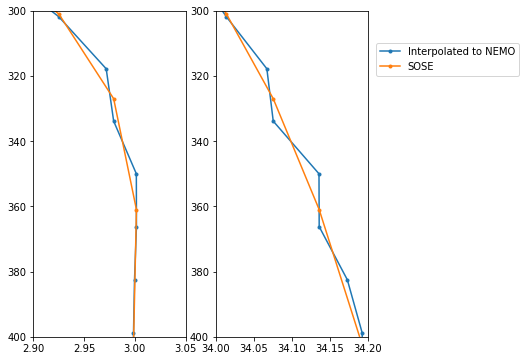

In [449]:
fig, ax = plt.subplots(1,2, figsize=(6,6))
    
ax[0].plot(Temp, SOSE_vert_interp.Z, '.-', label='Interpolated to NEMO')
ax[0].plot(SOSE_horizon_interp.THETA.isel(y=0, x=0), -1*SOSE_depths, '.-', label='SOSE')
ax[0].set_xlim(2.9, 3.05)

ax[1].plot(Salt, SOSE_vert_interp.Z, '.-', label='Interpolated to NEMO')
ax[1].plot(SOSE_horizon_interp.SALT.isel(y=0, x=0), -1*SOSE_depths, '.-', label='SOSE')
ax[1].set_xlim(34.0, 34.2)
ax[1].legend(loc=(1.05, 0.8))

for axis in ax.ravel():
    axis.invert_yaxis()
    axis.set_ylim(400,300)

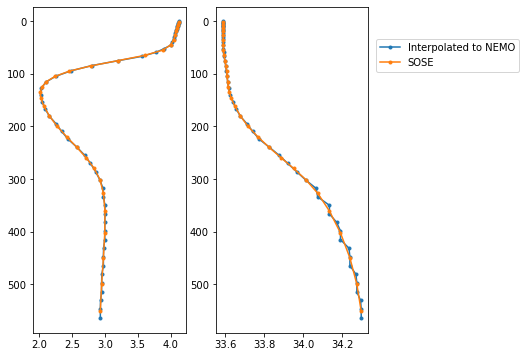

In [453]:
fig, ax = plt.subplots(1,2, figsize=(6,6))
    
ax[0].plot(Temp, mesh.gdept_0.isel(time_counter=0, y=y_ind, x=x_ind), '.-', label='Interpolated to NEMO')
ax[0].plot(SOSE_horizon_interp.THETA.isel(y=0, x=0), -1*SOSE_depths, '.-', label='SOSE')
ax[1].plot(Salt, mesh.gdept_0.isel(time_counter=0, y=y_ind, x=x_ind), '.-', label='Interpolated to NEMO')
ax[1].plot(SOSE_horizon_interp.SALT.isel(y=0, x=0), -1*SOSE_depths, '.-', label='SOSE')

ax[1].legend(loc=(1.05, 0.8))
for axis in ax.ravel():
    axis.invert_yaxis()

In [434]:
def interp_depth(source, source_edges, nemo_edges, n):
    # For a particular input nemo depth level, interpolate from source grid to nemo grid (conservatively nearest-neighbour)
    
    NEMO_top_edge = nemo_edges[0][n,:]; NEMO_bot_edge = nemo_edges[2][n,:];

    dataset = xr.Dataset({}).assign_coords(x=source.x, y=source.y)

    for var in source: # loop over the variables in the source dataset
        # find the source edges that fall within the depth ranges of the NEMO grid cells:
        Var = 0; 
        for zs in range(0,source.src_depth.size):
            src_top_edge = source_edges[0][zs,:]; src_bot_edge = source_edges[2][zs,:];

            Var = xr.where((NEMO_top_edge >= src_top_edge)*(NEMO_bot_edge < src_bot_edge), 
                           Var + (NEMO_bot_edge - NEMO_top_edge)* (source[var].isel(src_depth=zs)), Var)

            Var = xr.where((NEMO_top_edge >= src_top_edge)*(src_bot_edge < NEMO_bot_edge)*(src_bot_edge > NEMO_top_edge), 
                           Var + (src_bot_edge - NEMO_top_edge) * source[var].isel(src_depth=zs), Var)

            Var = xr.where((NEMO_top_edge < src_top_edge)*(src_bot_edge > NEMO_bot_edge)*(src_top_edge < NEMO_bot_edge), 
                           Var + (NEMO_bot_edge - src_top_edge) * source[var].isel(src_depth=zs), Var)

            Var = xr.where((NEMO_top_edge < src_top_edge)*(src_bot_edge < NEMO_bot_edge)*(src_top_edge < NEMO_bot_edge), 
                           Var + (src_bot_edge - src_top_edge) * source[var].isel(src_depth=zs), Var)

        Var = Var/(NEMO_bot_edge - NEMO_top_edge)
        dataset[var] = (('y', 'x'), Var.values)
        
    return dataset

In [370]:
nemo_edges = vertical_edges(mesh, mtype='nemo')
sose_edges = vertical_edges(SOSE_horizon_interp, mtype='SOSE')

model_BCs = []
for n, ndepth in enumerate(nemo_depths):
   
    source = xr.Dataset({'SALT':SOSE_horizon_interp.SALT, 'THETA':SOSE_horizon_interp.THETA}).assign_coords(x=nemo.nav_lon.isel(y=bdy_ind),
                                                                                                            y=[nemo.nav_lat.isel(y=bdy_ind, x=0)])

    # Interpolate slices from SOSE to NEMO depth levels
    data_interp = interp_depth(source, sose_edges, nemo_edges, n)
    
    # Add interpolated layers to dataset
    model_BCs.append(data_interp)
    
SOSE_vert_interp = xr.concat(model_BCs, dim='Z').assign_coords(Z=nemo_depths)

(121, 1440) (121, 1440)


/tmp/ipykernel_72013/327169634.py:23: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  cm2 = ax[1].pcolormesh(model_x, model_Z, model_T_proc.THETA, **kwargs_T)
/tmp/ipykernel_72013/327169634.py:25: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  cm4 = ax[3].pcolormesh(model_x, model_Z, model_S_proc.SALT, **kwargs_S)


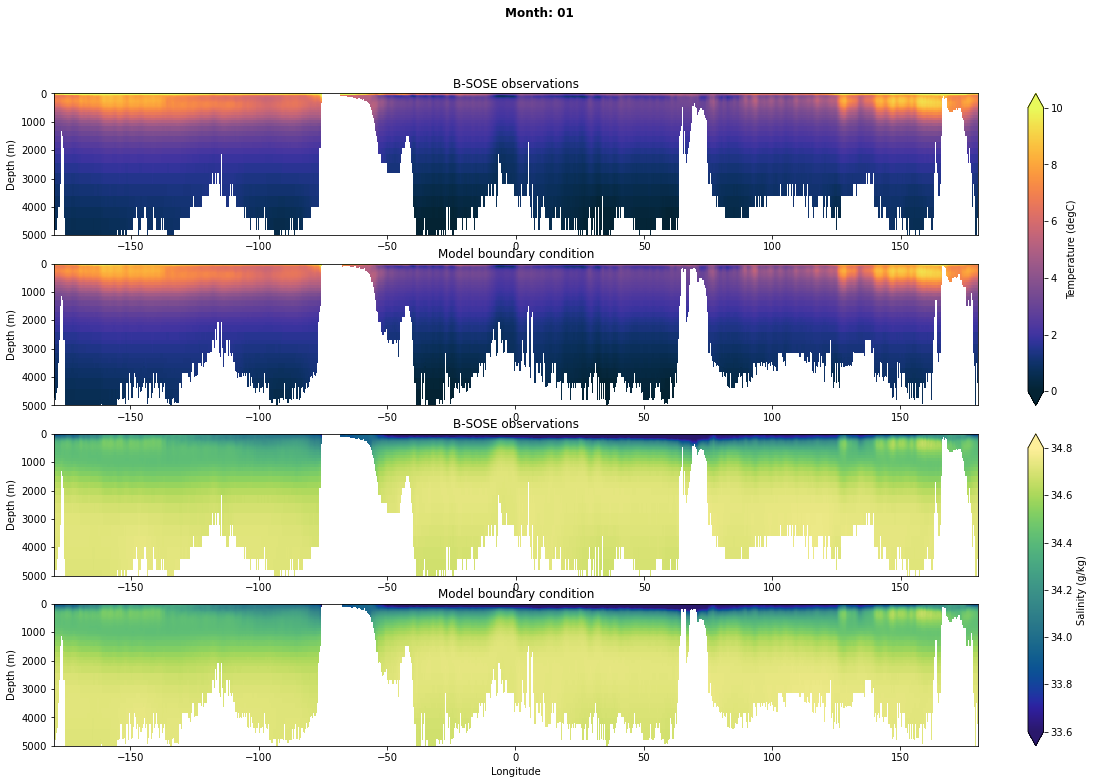

In [435]:
fig1 = {}
fig1[f'm{month:02}'],ax1 = plot_bdy_transect(month, SOSE_vert_interp.isel(y=0), SOSE_vert_interp.isel(y=0), SOSE_S.isel(YC=0), SOSE_T.isel(YC=0), 
                                             Trange=(0,10), Srange=(33.6, 34.8), ylim=(5000,0))

(121, 1440) (121, 1440)


/tmp/ipykernel_72013/327169634.py:23: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  cm2 = ax[1].pcolormesh(model_x, model_Z, model_T_proc.THETA, **kwargs_T)
/tmp/ipykernel_72013/327169634.py:25: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  cm4 = ax[3].pcolormesh(model_x, model_Z, model_S_proc.SALT, **kwargs_S)


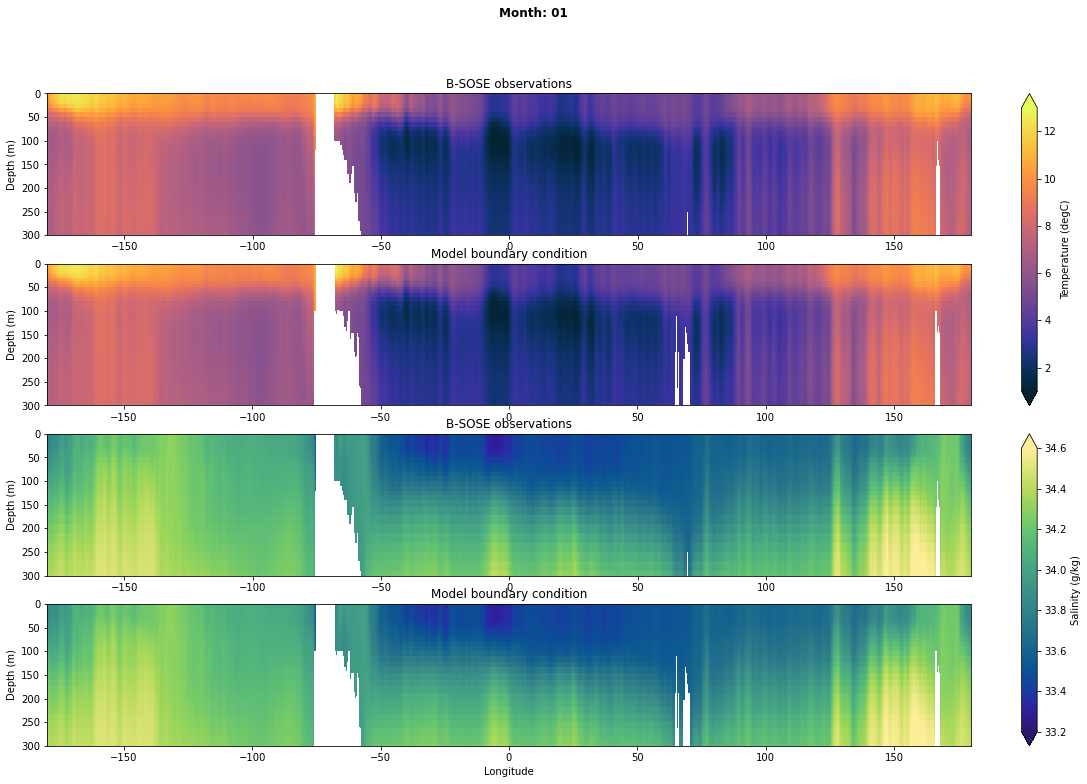

In [436]:
fig1 = {}
fig1[f'm{month:02}'] = plot_bdy_transect(month, SOSE_vert_interp.isel(y=0), SOSE_vert_interp.isel(y=0), SOSE_S.isel(YC=0), SOSE_T.isel(YC=0), 
                                         Trange=(1,13), Srange=(33.2, 34.6), ylim=(300,0))

##### Create climatology

In [18]:
folder_in = '/data/oceans_input/raw_input_data/BSOSE_i139/'

SOSE_var = xr.open_dataset(f'{folder_in}SSH_bsoseI139_2013to2021_5dy.nc')

for month in range(1,13):
    print(month)
    var_mean = SOSE_var.isel(time=(SOSE_var.time.dt.month == month)).mean(dim='time')
    var_mean.to_netcdf(f'{folder_SOSE}ETAN_climatology_m{month:02}.nc')

1
2
3
4
5
6
7
8
9
10
11
12
